## Data Processing

#### The first step in our Deep Learning workflow is to process the BRATS image data. The BRATS data is stored as DICOM images, which is a medical image data format. To access the DICOM images and convert them to numpy we will use the python package `SimpleITK`, which is a popular image processing library.

In [1]:
import SimpleITK as sitk
import os

import numpy as np
import matplotlib
import os

%matplotlib inline
matplotlib.rcParams.update({'font.size': 24})
import matplotlib.pyplot as plt


#Code to stop notebook from hiding plots with scrolling
from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def disable_scroll():
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")
    
disable_scroll()


<IPython.core.display.Javascript object>

autoscrolling long output is disabled


### Image modalities and reading the data

#### Medical imaging can make use of a number of modalities. Here will consider FLAIR-MRI images which stands for Fluid Attenuated Inversion Recovery - Magnetic Resonance Imaging. FLAIR-MRI decreases the signal from fluid in the body, allowing us to better see surrounding structures.

#### We will read the data by gathering a list of file names and feeding these to SimpleITK. Each image is converted to a 3D numpy array with dimensions Width x Height x Depth

In [2]:
data_path = '/mnt/hgfs/Medical-Data/BRATS-2015/BRATS2015_Training/HGG/'
flairs = []
segs = []
for root,dirs,files in os.walk(data_path):
    for f in files:
        if 'Flair' in f:
            flairs.append(root+'/'+f)
        if '.OT' in f:
            segs.append(root+'/'+f)
            
flairs = sorted(flairs)
segs = sorted(segs)

### Inspecting the data

#### Before reading all the data we can try plotting it to see what it looks like. Here we look at an image and its associated ground truth segmentation. Since the images are 3D, we can select a particular cross section and visualize it. We can see how the gliomas show up as bright spots in the images.

/mnt/hgfs/Medical-Data/BRATS-2015/BRATS2015_Training/HGG/brats_tcia_pat105_0001/VSD.Brain.XX.O.MR_Flair.35533/VSD.Brain.XX.O.MR_Flair.35533.mha
/mnt/hgfs/Medical-Data/BRATS-2015/BRATS2015_Training/HGG/brats_tcia_pat105_0001/VSD.Brain_3more.XX.O.OT.42283/VSD.Brain_3more.XX.O.OT.42283.mha
(155, 240, 240)
(155, 240, 240)


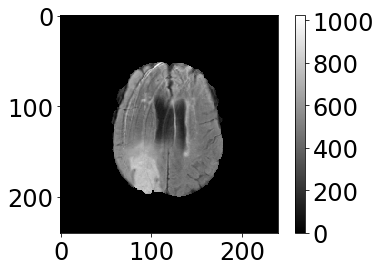

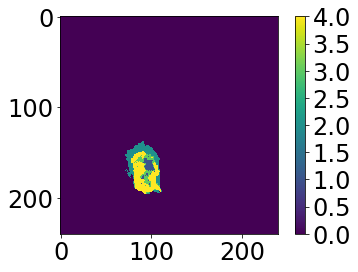

In [3]:
SLICE = 90
IMAGE_NUMBER = 20

print (flairs[IMAGE_NUMBER])
print (segs[IMAGE_NUMBER])

im1 = sitk.GetArrayFromImage(sitk.ReadImage(flairs[IMAGE_NUMBER]))
im2 = sitk.GetArrayFromImage(sitk.ReadImage(segs[IMAGE_NUMBER]))

print (im1.shape)
print (im2.shape)

plt.figure()
plt.grid('off')
plt.imshow(im1[SLICE,:,:],cmap='gray')
plt.colorbar()
plt.show()

plt.figure()
plt.grid('off')
plt.imshow(im2[SLICE,:,:])
plt.colorbar()
plt.show()

### Processing all of the images

#### Now that we know what the images look like we can start processing the entire dataset. We will extract 2D slices from all images and use them to train a 2D fully convolutional neural network.

#### Since the labeled images are typically sparse (few labeled pixels) we separate the dataset into a set where the ground truth images have few labeled pixels (negative set) and a set where the ground truth images have many labeled pixels (positive set). During training we can then sample from both these sets.

#### To store the data we use the HDF5 file format. HDF5 allows us to use the images to train our neural network without loading them all into memory.

#### Finally we also normalize the input image pixel values to be between 0 and 1 and we crop all images to a size of 128 x 128

In [4]:
def process_image_seg(image,segmentation,crop=128):
    image = image.astype(float)
    image = (image-np.amin(image))/(np.amax(image)-np.amin(image))
    
    N,H,W = image.shape
    
    x = image[:,H//2-crop//2:H//2+crop//2,W//2-crop//2:W//2+crop//2]
    y = segmentation[:,H//2-crop//2:H//2+crop//2,W//2-crop//2:W//2+crop//2]
    
    return x,y

def split_positive_negative(images,segmentations):
    negative_index = np.where(np.sum(segmentations,axis=(1,2))<1)
    positive_index = np.where(np.sum(segmentations,axis=(1,2))>=1)
    
    X_negative = images[negative_index]
    Y_negative = segmentations[negative_index]
    
    X_positive = images[positive_index]
    Y_positive = segmentations[positive_index]
    
    return X_positive,Y_positive,X_negative,Y_negative

In [5]:
def make_dataset(f,flairs,segs):
    i_positive = 0
    i_negative = 0
    
    X_p = f.create_dataset("X_positive", (100000, CROP_DIMS,CROP_DIMS), 
                           maxshape=(None, CROP_DIMS,CROP_DIMS))
    Y_p = f.create_dataset("Y_positive", (100000, CROP_DIMS,CROP_DIMS), 
                           maxshape=(None, CROP_DIMS,CROP_DIMS))
    X_n = f.create_dataset("X_negative", (100000, CROP_DIMS,CROP_DIMS), 
                           maxshape=(None, CROP_DIMS,CROP_DIMS))
    Y_n = f.create_dataset("Y_negative", (100000, CROP_DIMS,CROP_DIMS), 
                           maxshape=(None, CROP_DIMS,CROP_DIMS))

    for flair_file,seg_file in zip(flairs,segs):
        im1 = sitk.GetArrayFromImage(sitk.ReadImage(flair_file))
        im2 = sitk.GetArrayFromImage(sitk.ReadImage(seg_file))

        x_processed,y_processed = process_image_seg(im1,im2,CROP_DIMS)

        x_positive,y_positive,x_negative,y_negative = split_positive_negative(x_processed,
                                                                              y_processed)

        n_positive = len(x_positive)
        n_negative = len(x_negative)

        X_p[i_positive:i_positive+n_positive] = x_positive
        Y_p[i_positive:i_positive+n_positive] = y_positive

        X_n[i_negative:i_negative+n_negative] = x_negative
        Y_n[i_negative:i_negative+n_negative] = y_negative

        i_positive = i_positive + n_positive
        i_negative = i_negative + n_negative

        
    X_p.resize(i_positive,axis=0)
    Y_p.resize(i_positive,axis=0)
    X_n.resize(i_negative,axis=0)
    Y_n.resize(i_negative,axis=0)
    print ('found {} positive examples and {} negative examples'.format(i_positive,i_negative))

In [6]:
import h5py

CROP_DIMS = 128

f_train = h5py.File('brats_train.h5','w')
f_test = h5py.File('brats_test.h5','w')

make_dataset(f_train,flairs[:-20],segs[:-20])
make_dataset(f_test,flairs[-20:],segs[-20:])

f_train.close()
f_test.close()


/home/sara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


found 14622 positive examples and 16378 negative examples
found 1474 positive examples and 1626 negative examples
